Please enter stock tickers separated by commas (e.g. AAPL,MSFT,GOOGL):  TGT, PYPL, FUBO, TSLA


Please provide weights for TGT, PYPL, FUBO, TSLA respectively, separated by commas (e.g. 0.4,0.3,0.3): 


 0.4, 0.2, 0.2, 0.2
Please enter the number of years for the simulation (3, 4, or 5):  4


[*********************100%%**********************]  4 of 4 completed
             FUBO        PYPL         TGT       TSLA          TGT  \
            close       close       close      close daily_return   
Date                                                                
2020-01-02   9.97  110.750000  116.828636  28.684000          NaN   
2020-01-03  10.02  108.760002  115.614655  29.534000    -0.010391   
2020-01-06  10.27  110.169998  114.521156  30.102667    -0.009458   
2020-01-07  10.26  109.669998  114.725044  31.270666     0.001780   
2020-01-08  10.26  111.820000  114.354347  32.809334    -0.003231   

                   PYPL         FUBO         TSLA  
           daily_return daily_return daily_return  
Date                                               
2020-01-02          NaN          NaN          NaN  
2020-01-03    -0.017968     0.005015     0.029633  
2020-01-06     0.012964     0.024950     0.019255  
2020-01-07    -0.004538    -0.000974     0.038801  
2020-01-08    

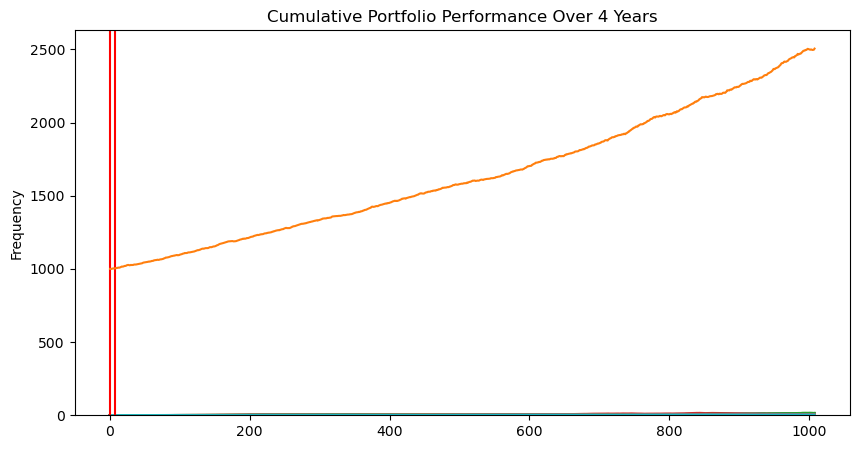

In [23]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from MCForecastTools import MCSimulation
import warnings
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

def get_stock_data(tickers, start_date="2020-01-01", end_date=datetime.now().strftime('%Y-%m-%d')):
    stock_data = yf.download(tickers, start=start_date, end=end_date)["Adj Close"]
    return stock_data

# Prompt the user for tickers
user_input = input("Please enter stock tickers separated by commas (e.g. AAPL,MSFT,GOOGL): ")
tickers = [x.strip().upper() for x in user_input.split(",")]

# Prompt the user for the weights of each ticker
print(f"Please provide weights for {', '.join(tickers)} respectively, separated by commas (e.g. 0.4,0.3,0.3): ")
weights_input = input().split(',')
weights = [float(x.strip()) for x in weights_input]

# Validate the weights sum to 1
while not (0.99 <= sum(weights) <= 1.01):  # Tolerating small rounding errors
    print("Weights do not sum up to 1. Please try again.")
    print(f"Please provide weights for {', '.join(tickers)} respectively, separated by commas: ")
    weights_input = input().split(',')
    weights = [float(x.strip()) for x in weights_input]

# Prompt the user to choose the simulation length
user_input_years = input("Please enter the number of years for the simulation (3, 4, or 5): ")
while user_input_years not in ["3", "4", "5"]:
    print("Invalid input. Please enter 3, 4, or 5.")
    user_input_years = input("Please enter the number of years for the simulation (3, 4, or 5): ")

num_years = int(user_input_years)

# Fetch the stock data using the function
portfolio_data = get_stock_data(tickers)

# Structure portfolio_data to have multi-level columns
portfolio_data.columns = pd.MultiIndex.from_product([portfolio_data.columns, ['close']])

# Calculate daily returns and add to the portfolio data
for ticker in tickers:
    portfolio_data[(ticker, 'daily_return')] = portfolio_data[ticker]['close'].pct_change()

# Display a portion of the data to verify structure
print(portfolio_data.head())

# Run the Monte Carlo Simulation
mc_sim = MCSimulation(portfolio_data=portfolio_data, weights=weights, num_simulation=500, num_trading_days=252*num_years)
mc_sim.calc_cumulative_return()
mc_sim.plot_simulation()
mc_sim.plot_distribution()

# Compute summary statistics from the simulated daily returns
simulated_returns_data = {
    "mean": list(mc_sim.simulated_return.mean(axis=1)),
    "median": list(mc_sim.simulated_return.median(axis=1)),
    "min": list(mc_sim.simulated_return.min(axis=1)),
    "max": list(mc_sim.simulated_return.max(axis=1))
}

# Create a DataFrame with the summary statistics
df_simulated_returns = pd.DataFrame(simulated_returns_data)

# Display sample data
print(df_simulated_returns.head())

# Calculate portfolio performance over time under `initial_investment`
initial_investment = 1000
cumulative_pnl = initial_investment * df_simulated_returns['mean']

# Plot the cumulative returns over time
cumulative_pnl.plot(figsize=(10,5))
plt.title(f"Cumulative Portfolio Performance Over {num_years} Years")
plt.show()


